# Analisis Kualitas Hidup dan Lingkungan

In [24]:
import requests
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

## Preparing Data

In [25]:
urls = {
    "tutupan_lahan": "https://geoserver.mapid.io/layers_new/get_layer?api_key=1f190186ad52452a9ab5d65b93ee48e1&layer_id=699409ee02ca69c98148cc31&project_id=698ad53d598e70fb1d6e3db3",
    "no2": "https://geoserver.mapid.io/layers_new/get_layer?api_key=1f190186ad52452a9ab5d65b93ee48e1&layer_id=699410ef02ca69c98149b237&project_id=698ad53d598e70fb1d6e3db3",
    "bahaya_banjir": "https://geoserver.mapid.io/layers_new/get_layer?api_key=1f190186ad52452a9ab5d65b93ee48e1&layer_id=6993f0c19e209fa19401c30d&project_id=698ad53d598e70fb1d6e3db3",
    "bahaya_tsunami": "https://geoserver.mapid.io/layers_new/get_layer?api_key=1f190186ad52452a9ab5d65b93ee48e1&layer_id=6993f0fc9e209fa19401d7bf&project_id=698ad53d598e70fb1d6e3db3",
    "emisi_karbon": "https://geoserver.mapid.io/layers_new/get_layer?api_key=1f190186ad52452a9ab5d65b93ee48e1&layer_id=6993f12ce12474627acbeb21&project_id=698ad53d598e70fb1d6e3db3",
    "ntl": "https://geoserver.mapid.io/layers_new/get_layer?api_key=1f190186ad52452a9ab5d65b93ee48e1&layer_id=6993f15002ca69c9814602d2&project_id=698ad53d598e70fb1d6e3db3",
    "indeks_ekologi": "https://geoserver.mapid.io/layers_new/get_layer?api_key=1f190186ad52452a9ab5d65b93ee48e1&layer_id=6993f1759e209fa19401e70b&project_id=698ad53d598e70fb1d6e3db3",
    "batas_admin": "https://geoserver.mapid.io/layers_new/get_layer?api_key=1f190186ad52452a9ab5d65b93ee48e1&layer_id=69940a5402ca69c98148cf9b&project_id=698ad53d598e70fb1d6e3db3", 
}

def get_gdf_from_api(url):
    response = requests.get(url)
    if response.status_code == 200:
        geojson = response.json()
        gdf = gpd.GeoDataFrame.from_features(geojson['features'])
        print(f"Berhasil mengambil data dari {url.split('&layer_id=')[1][:10]}...")
        return gdf
    else:
        print(f"Gagal mengambil data dari {url}")
        return gpd.GeoDataFrame()

# Membaca semua data ke dalam dictionary GeoDataFrame
gdfs = {}
for key, url in urls.items():
    gdfs[key] = get_gdf_from_api(url)

Berhasil mengambil data dari 699409ee02...
Berhasil mengambil data dari 699410ef02...
Berhasil mengambil data dari 6993f0c19e...
Berhasil mengambil data dari 6993f0fc9e...
Berhasil mengambil data dari 6993f12ce1...
Berhasil mengambil data dari 6993f15002...
Berhasil mengambil data dari 6993f1759e...
Berhasil mengambil data dari 69940a5402...


Semua layer berhasil diproyeksikan dan dipotong ke batas admin.


/var/folders/p0/dds400fd5ys_739l634yb7ch0000gn/T/ipykernel_19205/1000292860.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  admin_geom = batas_admin.unary_union  # dissolve jadi satu polygon
/var/folders/p0/dds400fd5ys_739l634yb7ch0000gn/T/ipykernel_19205/1000292860.py:43: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  tsunami_union = tsunami_raw.unary_union


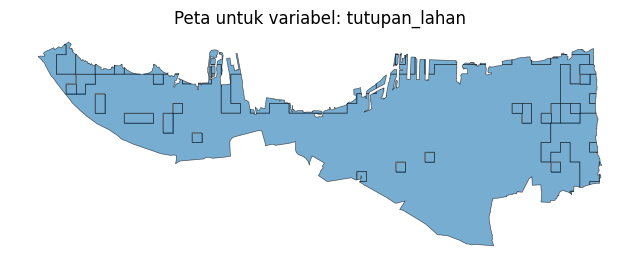

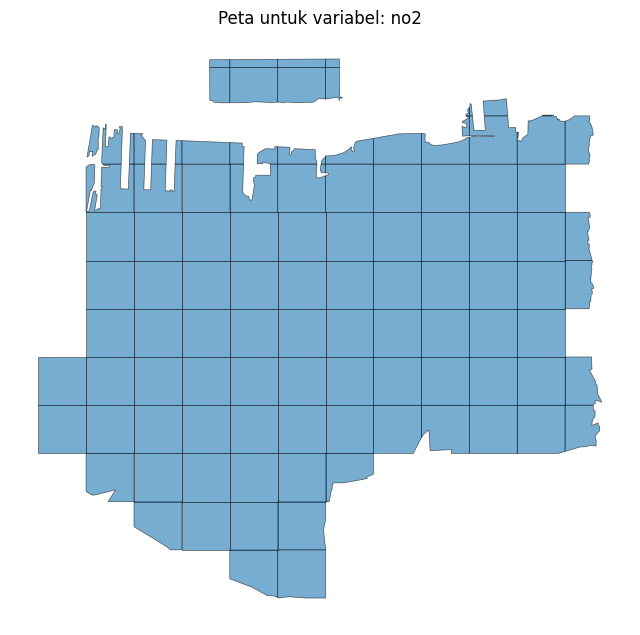

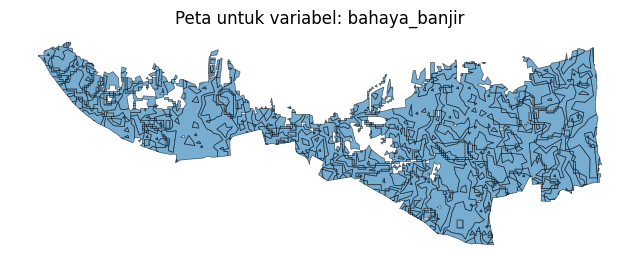

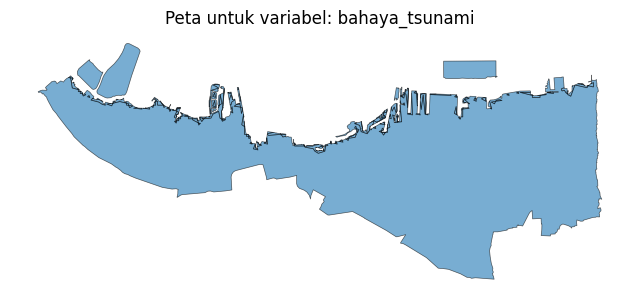

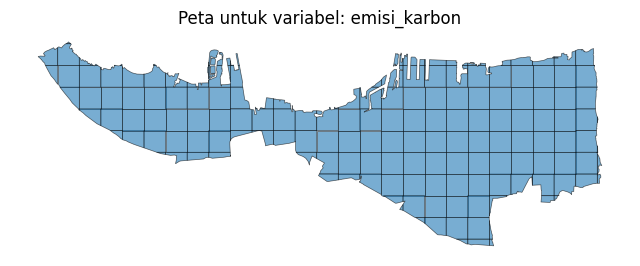

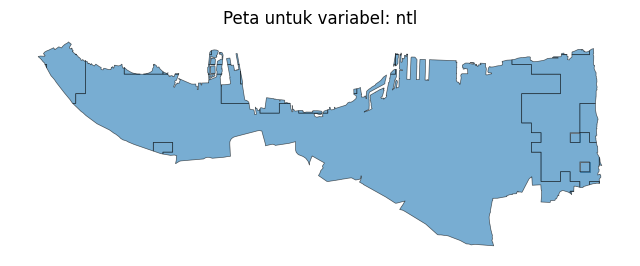

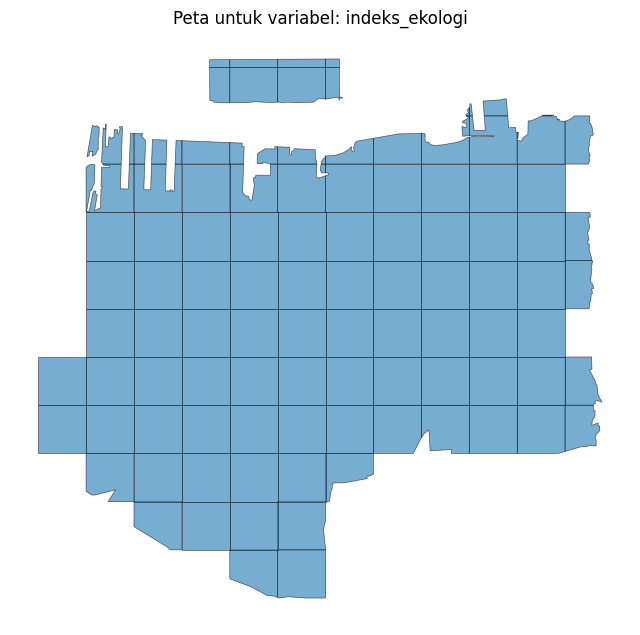

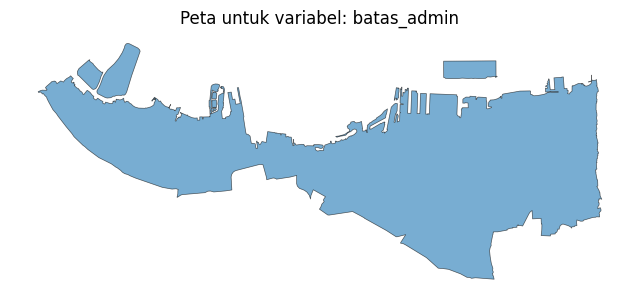

In [26]:
from shapely import wkb

# 1. Isi nilai kosong & pastikan CRS
for key, gdf in gdfs.items():
    for col in gdf.columns:
        gdf[col] = gdf[col].fillna("TIDAK DIKETAHUI") if gdf[col].dtype == "O" else gdf[col].fillna(0)
    if gdf.crs is None or gdf.crs.to_epsg() != 4326:
        gdf.set_crs(epsg=4326, inplace=True)

def drop_z(geom):
    if geom is None or geom.is_empty:
        return geom
    if hasattr(geom, "has_z") and geom.has_z:
        return wkb.loads(wkb.dumps(geom, output_dimension=2))
    return geom

# 2. Siapkan batas admin dan clip manual
batas_admin = gdfs["batas_admin"].copy()
batas_admin["geometry"] = batas_admin.geometry.apply(drop_z)
batas_admin = batas_admin.set_crs(epsg=4326, allow_override=True)

admin_geom = batas_admin.unary_union  # dissolve jadi satu polygon
clipper = gpd.GeoDataFrame({"geometry": [admin_geom]}, crs="EPSG:4326")

for key, gdf in gdfs.items():
    gdf = gdf.copy()
    gdf["geometry"] = gdf.geometry.apply(drop_z)
    gdf = gdf.set_crs(epsg=4326, allow_override=True)

    if key != "batas_admin":
        mask = gdf.geometry.intersects(admin_geom)
        gdf = gdf[mask].copy()
        gdf["geometry"] = gdf.geometry.intersection(admin_geom)

    gdfs[key] = gdf

print("Semua layer berhasil diproyeksikan dan dipotong ke batas admin.")

# tsunami update
tsunami_raw = gdfs["bahaya_tsunami"].copy()
tsunami_raw["geometry"] = tsunami_raw.geometry.apply(drop_z)
tsunami_raw = tsunami_raw.to_crs("EPSG:4326")
tsunami_union = tsunami_raw.unary_union
if tsunami_union.is_empty:
    raise ValueError("Geometri tsunami kosong setelah clipping.")
if not tsunami_union.is_valid:
    tsunami_union = tsunami_union.buffer(0)
impacted_geom = admin_geom.intersection(tsunami_union)
safe_geom = admin_geom.difference(tsunami_union)
tsunami_features = []
if not impacted_geom.is_empty:
    tsunami_features.append(
        {"status_tsunami": "Terdampak", "score_tsunami": 0, "geometry": impacted_geom}
    )
if not safe_geom.is_empty:
    tsunami_features.append(
        {"status_tsunami": "Tidak Terdampak", "score_tsunami": 1, "geometry": safe_geom}
    )
gdfs["bahaya_tsunami"] = gpd.GeoDataFrame(tsunami_features, crs="EPSG:4326")


# 4. Plot setiap layer
for key, gdf in gdfs.items():
    ax = gdf.plot(figsize=(8, 8), edgecolor="black", linewidth=0.5, alpha=0.6)
    ax.set_title(f"Peta untuk variabel: {key}")
    ax.set_axis_off()
    plt.show()

In [27]:
for key, gdf in gdfs.items():
    print(f"=== {key.upper()} ===")
    print("Kolom:", list(gdf.columns))
    print("Jumlah baris:", len(gdf))
    display(gdf.head()) 

=== TUTUPAN_LAHAN ===
Kolom: ['geometry', 'CLASS', 'KELAS']
Jumlah baris: 32


,geometry,CLASS,KELAS
0,"MULTIPOLYGON (((106.72568 -6.08938, 106.7259 -...",WATER,AIR
1,"MULTIPOLYGON (((106.88091 -6.16262, 106.88087 ...",BUILT AREA,WILAYAH TERBANGUN
2,"POLYGON ((106.97024 -6.10639, 106.97028 -6.106...",WATER,AIR
3,"POLYGON ((106.96689 -6.10405, 106.96689 -6.108...",CROPS,LAHAN PERTANIAN DAN LAHAN PERKEBUNAN
4,"POLYGON ((106.96992 -6.11431, 106.96987 -6.114...",BUILT AREA,WILAYAH TERBANGUN


=== NO2 ===
Kolom: ['geometry', 'fid', 'ID_GRID', 'RATA-RATA', 'ID_PROV', 'PROVINSI', 'ID_KABKOT']
Jumlah baris: 100


,geometry,fid,ID_GRID,RATA-RATA,ID_PROV,PROVINSI,ID_KABKOT
0,"POLYGON ((106.97098 -6.14673, 106.97101 -6.147...",5119593,5119593,0.000083,31,DKI JAKARTA,31.72
1,"POLYGON ((106.97065 -6.13774, 106.97074 -6.140...",5119592,5119592,0.000081,31,DKI JAKARTA,31.72
2,"POLYGON ((106.97076 -6.11976, 106.97086 -6.120...",5119590,5119590,0.000080,31,DKI JAKARTA,31.72
3,"POLYGON ((106.97027 -6.11077, 106.97044 -6.111...",5119589,5119589,0.000074,31,DKI JAKARTA,31.72
4,"POLYGON ((106.97032 -6.09278, 106.97033 -6.093...",5119587,5119587,0.000069,31,DKI JAKARTA,31.72


=== BAHAYA_BANJIR ===
Kolom: ['geometry', 'Kelas']
Jumlah baris: 863


,geometry,Kelas
0,"POLYGON ((106.72608 -6.08976, 106.72623 -6.089...",Sangat Rendah
1,"POLYGON ((106.72557 -6.09156, 106.72467 -6.091...",Cukup Rendah
2,"POLYGON ((106.72467 -6.09156, 106.72557 -6.091...",Sedang
3,"POLYGON ((106.72107 -6.09336, 106.7195 -6.0925...",Tinggi
4,"POLYGON ((106.71548 -6.09575, 106.71627 -6.094...",Cukup Rendah


=== BAHAYA_TSUNAMI ===
Kolom: ['status_tsunami', 'score_tsunami', 'geometry']
Jumlah baris: 2


,status_tsunami,score_tsunami,geometry
0,Terdampak,0,"MULTIPOLYGON (((106.72495 -6.0897, 106.72503 -..."
1,Tidak Terdampak,1,"MULTIPOLYGON (((106.97033 -6.0942, 106.97045 -..."


=== EMISI_KARBON ===
Kolom: ['geometry', 'Densitas (µg/m³)', 'ISPU (Indeks Standar Pencemar Udara)', 'Kategori ISPU (Indeks Standar Pencemar Udara)', 'Kelas']
Jumlah baris: 164


,geometry,Densitas (µg/m³),ISPU (Indeks Standar Pencemar Udara),Kategori ISPU (Indeks Standar Pencemar Udara),Kelas
0,"POLYGON ((106.91049 -6.18003, 106.91049 -6.182...",85,53,Sedang,Berbahaya
1,"POLYGON ((106.91429 -6.18248, 106.91425 -6.182...",84,53,Sedang,Berbahaya
2,"POLYGON ((106.92182 -6.18021, 106.9217 -6.1804...",83,52,Sedang,Berbahaya
3,"POLYGON ((106.72568 -6.08938, 106.7259 -6.0896...",74,46,Baik,Berbahaya
4,"POLYGON ((106.71272 -6.09712, 106.71272 -6.097...",76,47,Baik,Berbahaya


=== NTL ===
Kolom: ['geometry', 'fid', 'DN', 'KELAS', 'CLASS', 'INTENSITAS (nW/sr/cm²)']
Jumlah baris: 19


,geometry,fid,DN,KELAS,CLASS,INTENSITAS (nW/sr/cm²)
0,"POLYGON ((106.95866 -6.15809, 106.95859 -6.159...",29372,4,CAHAYA SEDANG,MEDIUM LIGHTS,10 - 20
1,"POLYGON ((106.76477 -6.13549, 106.77375 -6.135...",29344,4,CAHAYA SEDANG,MEDIUM LIGHTS,10 - 20
2,"POLYGON ((106.9624 -6.131, 106.9624 -6.13549, ...",29335,3,CAHAYA RENDAH,LOW LIGHTS,5 - 10
3,"MULTIPOLYGON (((106.83293 -6.12075, 106.83407 ...",29315,4,CAHAYA SEDANG,MEDIUM LIGHTS,10 - 20
4,"POLYGON ((106.85789 -6.11095, 106.85806 -6.110...",29291,4,CAHAYA SEDANG,MEDIUM LIGHTS,10 - 20


=== INDEKS_EKOLOGI ===
Kolom: ['geometry', 'fid', 'ID_GRID', 'INDEKS', 'STATUS', 'ID_PROV', 'PROVINSI', 'ID_KABKOT', 'KABKOT', 'ID_KEC', 'KECAMATAN', 'ID_DESA', 'DESA']
Jumlah baris: 100


,geometry,fid,ID_GRID,INDEKS,STATUS,ID_PROV,PROVINSI,ID_KABKOT,KABKOT,ID_KEC,KECAMATAN,ID_DESA,DESA
0,"POLYGON ((106.97098 -6.14673, 106.97101 -6.147...",499167,5119593,0.405225,SEDANG,31,DKI JAKARTA,31.72,KOTA ADM. JAKARTA UTARA,31.72.04,CILINCING,31.72.04.1006,ROROTAN
1,"POLYGON ((106.97065 -6.13774, 106.97074 -6.140...",499166,5119592,0.378035,CUKUP,31,DKI JAKARTA,31.72,KOTA ADM. JAKARTA UTARA,31.72.04,CILINCING,31.72.04.1006,ROROTAN
2,"POLYGON ((106.97076 -6.11976, 106.97086 -6.120...",499164,5119590,0.311556,CUKUP,31,DKI JAKARTA,31.72,KOTA ADM. JAKARTA UTARA,31.72.04,CILINCING,31.72.04.1003,MARUNDA
3,"POLYGON ((106.97027 -6.11077, 106.97044 -6.111...",499163,5119589,0.282547,CUKUP,31,DKI JAKARTA,31.72,KOTA ADM. JAKARTA UTARA,31.72.04,CILINCING,31.72.04.1003,MARUNDA
4,"POLYGON ((106.97032 -6.09278, 106.97033 -6.093...",499161,5119587,0.328497,CUKUP,31,DKI JAKARTA,31.72,KOTA ADM. JAKARTA UTARA,31.72.04,CILINCING,31.72.04.1003,MARUNDA


=== BATAS_ADMIN ===
Kolom: ['geometry', 'fid', 'ID_PROV', 'PROVINSI', 'ID_KABKOT', 'KABKOT']
Jumlah baris: 8


,geometry,fid,ID_PROV,PROVINSI,ID_KABKOT,KABKOT
0,"POLYGON ((106.92332 -6.08993, 106.92324 -6.089...",19983,31,DKI JAKARTA,31.72,KOTA ADM. JAKARTA UTARA
1,"POLYGON ((106.74908 -6.09818, 106.74798 -6.098...",19983,31,DKI JAKARTA,31.72,KOTA ADM. JAKARTA UTARA
2,"POLYGON ((106.7347 -6.08251, 106.73595 -6.0834...",19983,31,DKI JAKARTA,31.72,KOTA ADM. JAKARTA UTARA
3,"POLYGON ((106.8781 -6.09472, 106.87809 -6.0949...",19983,31,DKI JAKARTA,31.72,KOTA ADM. JAKARTA UTARA
4,"POLYGON ((106.79304 -6.09679, 106.79303 -6.096...",19983,31,DKI JAKARTA,31.72,KOTA ADM. JAKARTA UTARA


## Klasifikasi Variabel

In [28]:
## LandCover
unique_classes_lc = gdfs["tutupan_lahan"]["CLASS"].unique()
print("Daftar CLASS:")
for val in sorted(unique_classes_lc):
    print("-", val)

lc_scores = {
    "TREES": 1.0,
    "FLOODED VEGETATION": 0.9,
    "WATER": 0.8,
    "CROPS": 0.6,
    "RANGELAND": 0.5,
    "BARE GROUND": 0.3,
    "BUILT AREA": 0.1,
}

gdf_lc = gdfs["tutupan_lahan"].copy()
gdf_lc["score_tutupan"] = gdf_lc["CLASS"].map(lc_scores).fillna(0.5)
gdfs["tutupan_lahan"] = gdf_lc

print("Kolom score_tutupan ditambahkan.")

Daftar CLASS:
- BARE GROUND
- BUILT AREA
- CROPS
- FLOODED VEGETATION
- RANGELAND
- TREES
- WATER
Kolom score_tutupan ditambahkan.


In [29]:
## NO2
no2 = gdfs["no2"].copy()

min_val = no2["RATA-RATA"].min()
max_val = no2["RATA-RATA"].max()
rng = max_val - min_val

no2["score_no2"] = 1 - (no2["RATA-RATA"] - min_val) / rng
no2["score_no2"] = no2["score_no2"].clip(0, 1)

gdfs["no2"] = no2
print(
    f"score_no2 ditambahkan (RATA-RATA min={min_val:.6f}, "
    f"max={max_val:.6f}, nilai rendah → skor tinggi)."
)

score_no2 ditambahkan (RATA-RATA min=0.000064, max=0.000136, nilai rendah → skor tinggi).


In [30]:
## Banjir
unique_classes_banjir = gdfs["bahaya_banjir"]["Kelas"].unique()
print("Daftar kelas bahaya banjir:")
for val in sorted(unique_classes_banjir):
    print("-", val)

banjir_scores = {
    "Sangat Rendah": 1.0,
    "Cukup Rendah": 0.8,
    "Sedang": 0.5,
    "Cukup Tinggi": 0.3,
    "Tinggi": 0.1,
}

gdf_banjir = gdfs["bahaya_banjir"].copy()
gdf_banjir["score_banjir"] = gdf_banjir["Kelas"].map(banjir_scores).fillna(0.5)
gdfs["bahaya_banjir"] = gdf_banjir

print("Kolom score_banjir ditambahkan.")


Daftar kelas bahaya banjir:
- Cukup Rendah
- Cukup Tinggi
- Sangat Rendah
- Sedang
- Tinggi
Kolom score_banjir ditambahkan.


In [31]:
## tsunami
unique_classes_tsunami = gdfs["bahaya_tsunami"]["score_tsunami"].unique()
print("Daftar score:")
for val in sorted(unique_classes_tsunami):
    print("-", val)

Daftar score:
- 0
- 1


In [32]:
## emisi karbon
emisi = gdfs["emisi_karbon"].copy()
col_ispu = "ISPU (Indeks Standar Pencemar Udara)"

min_val = emisi[col_ispu].min()
max_val = emisi[col_ispu].max()
rng = max_val - min_val

emisi["score_emisi"] = 1 - (emisi[col_ispu] - min_val) / rng
emisi["score_emisi"] = emisi["score_emisi"].clip(0, 1)

gdfs["emisi_karbon"] = emisi
print(
    f"score_emisi ditambahkan (ISPU min={min_val:.2f}, "
    f"max={max_val:.2f}; nilai rendah → skor tinggi)."
)


score_emisi ditambahkan (ISPU min=43.00, max=57.00; nilai rendah → skor tinggi).


In [33]:
## NTL
import re

ntl = gdfs["ntl"].copy()
col_int = "INTENSITAS (nW/sr/cm²)"

def parse_intensity(val):
    if isinstance(val, (int, float)):
        return float(val)
    if isinstance(val, str):
        numbers = [float(x) for x in re.findall(r"[\d\.]+", val)]
        if len(numbers) == 1:
            return numbers[0]
        if len(numbers) >= 2:
            return sum(numbers[:2]) / 2  # rata-rata rentang
    return np.nan

ntl["_intensity_val"] = ntl[col_int].apply(parse_intensity)

min_val = ntl["_intensity_val"].min()
max_val = ntl["_intensity_val"].max()
rng = max_val - min_val

ntl["score_ntl"] = 1 - (ntl["_intensity_val"] - min_val) / rng
ntl["score_ntl"] = ntl["score_ntl"].clip(0, 1)

gdfs["ntl"] = ntl.drop(columns="_intensity_val")

print(
    f"score_ntl ditambahkan (intensitas min={min_val:.2f}, "
    f"max={max_val:.2f}; nilai cahaya rendah → skor tinggi)."
)

score_ntl ditambahkan (intensitas min=4.00, max=20.00; nilai cahaya rendah → skor tinggi).


In [34]:
## indeks ekologi
indeks = gdfs["indeks_ekologi"].copy()
col_idx = "INDEKS"

min_val = indeks[col_idx].min()
max_val = indeks[col_idx].max()
rng = max_val - min_val

indeks["score_ekologi"] = (indeks[col_idx] - min_val) / rng
indeks["score_ekologi"] = indeks["score_ekologi"].clip(0, 1)

gdfs["indeks_ekologi"] = indeks
print(
    f"score_ekologi ditambahkan (INDEKS min={min_val:.3f}, "
    f"max={max_val:.3f}; nilai tinggi → skor tinggi)."
)


score_ekologi ditambahkan (INDEKS min=0.065, max=0.515; nilai tinggi → skor tinggi).


=== TUTUPAN_LAHAN ===


,score_tutupan
0,0.8
1,0.1
2,0.8
3,0.6
4,0.1


=== NO2 ===


,score_no2
0,0.739619
1,0.767474
2,0.780731
3,0.858645
4,0.929551


=== BAHAYA_BANJIR ===


,score_banjir
0,1.0
1,0.8
2,0.5
3,0.1
4,0.8


=== BAHAYA_TSUNAMI ===


,score_tsunami
0,0
1,1


=== EMISI_KARBON ===


,score_emisi
0,0.285714
1,0.285714
2,0.357143
3,0.785714
4,0.714286


=== NTL ===


,score_ntl
0,0.31250
1,0.31250
2,0.78125
3,0.31250
4,0.31250


=== INDEKS_EKOLOGI ===


,score_ekologi
0,0.756488
1,0.696104
2,0.548470
3,0.484048
4,0.586092


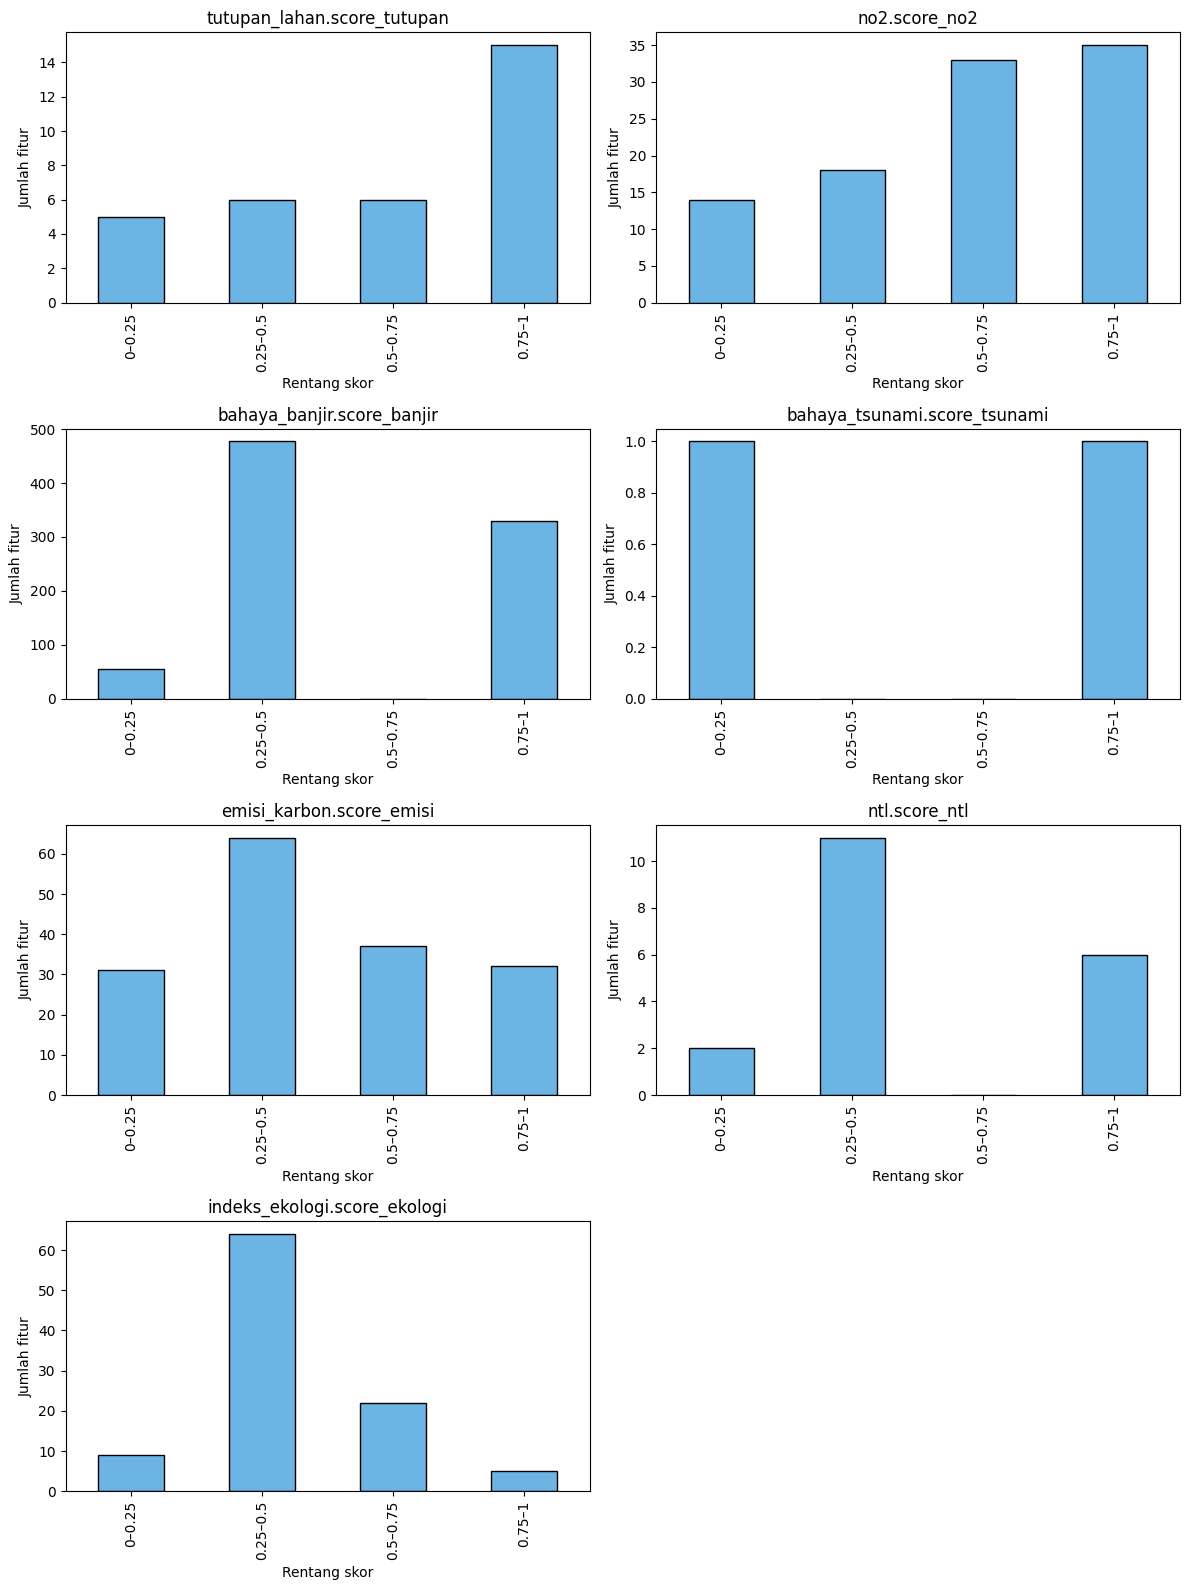

In [35]:
from math import ceil

for key, gdf in gdfs.items():
    score_cols = [c for c in gdf.columns if "score" in c.lower()]
    if score_cols:
        print(f"=== {key.upper()} ===")
        display(gdf[score_cols].head())

bins = [0, 0.25, 0.5, 0.75, 1.0]
labels = ["0–0.25", "0.25–0.5", "0.5–0.75", "0.75–1"]
score_infos = []

for key, gdf in gdfs.items():
    for col in [c for c in gdf.columns if c.lower().startswith("score")]:
        cat = pd.cut(gdf[col].clip(0, 1), bins=bins, labels=labels, include_lowest=True)
        score_infos.append((f"{key}.{col}", cat.value_counts().sort_index()))

n = len(score_infos)
cols = 2
rows = ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, (title, counts) in zip(axes, score_infos):
    counts.plot(kind="bar", color="#6cb4e4", edgecolor="black", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Rentang skor")
    ax.set_ylabel("Jumlah fitur")

# Kosongkan axes yang tak terpakai
for ax in axes[len(score_infos):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

## Multi Criteria Decision Analysis

In [36]:
## IKL - Indeks Kualitas Lingkungan
weights = {
    "score_tutupan": 0.15,
    "score_no2": 0.15,
    "score_banjir": 0.15,
    "score_tsunami": 0.10,
    "score_emisi": 0.15,
    "score_ntl": 0.10,
    "score_ekologi": 0.20,
}

ikl = gdfs["no2"][["ID_GRID", "geometry", "score_no2"]].copy()

def add_score(target, layer_key, score_col, id_field="ID_GRID"):
    layer = gdfs[layer_key].copy()
    cols = ["geometry", score_col]
    if id_field and id_field in layer.columns:
        cols.append(id_field)
    layer = layer[cols]

    # merge langsung jika kedua layer punya ID field yang sama
    if id_field and id_field in target.columns and id_field in layer.columns:
        return target.merge(layer[[id_field, score_col]], on=id_field, how="left")

    # overlay + rata-rata tertimbang luas ketika layer tidak punya ID_GRID
    base = target[["ID_GRID", "geometry"]]
    overlay = gpd.overlay(base, layer[["geometry", score_col]], how="intersection")

    if overlay.empty:
        target[score_col] = target.get(score_col, 0.5)
        return target

    overlay["area"] = overlay.geometry.area
    agg = (
        overlay.groupby("ID_GRID")
        .apply(lambda df: (df[score_col] * df["area"]).sum() / df["area"].sum())
        .rename(score_col)
        .reset_index()
    )

    target = target.drop(columns=[score_col], errors="ignore")
    target = target.merge(agg, on="ID_GRID", how="left")
    return target

ikl = add_score(ikl, "tutupan_lahan", "score_tutupan", id_field=None)
ikl = add_score(ikl, "bahaya_banjir", "score_banjir", id_field=None)
ikl = add_score(ikl, "bahaya_tsunami", "score_tsunami", id_field=None)
ikl = add_score(ikl, "emisi_karbon", "score_emisi", id_field=None)
ikl = add_score(ikl, "ntl", "score_ntl", id_field=None)
ikl = add_score(ikl, "indeks_ekologi", "score_ekologi")

for col in weights:
    ikl[col] = ikl.get(col, 0.5).fillna(0.5)

ikl["IKL"] = sum(weights[col] * ikl[col] for col in weights)

bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["Sangat Rendah", "Rendah", "Sedang", "Tinggi", "Sangat Tinggi"]
ikl["IKL_KELAS"] = pd.cut(ikl["IKL"].clip(0, 1), bins=bins, labels=labels, include_lowest=True)

display(ikl.head())

/var/folders/p0/dds400fd5ys_739l634yb7ch0000gn/T/ipykernel_19205/3795389761.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlay["area"] = overlay.geometry.area
/var/folders/p0/dds400fd5ys_739l634yb7ch0000gn/T/ipykernel_19205/3795389761.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df[score_col] * df["area"]).sum() / df["area"].sum())
/var/folders/p0/dds400fd5ys_739l634yb7ch0000gn/T/ipykernel_19205/3795389761.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-

,ID_GRID,geometry,score_no2,score_tutupan,score_banjir,score_tsunami,score_emisi,score_ntl,score_ekologi,IKL,IKL_KELAS
0,5119593,"POLYGON ((106.97098 -6.14673, 106.97101 -6.147...",0.739619,0.531921,0.240332,1.000000,0.796618,0.307256,0.756488,0.628297,Tinggi
1,5119592,"POLYGON ((106.97065 -6.13774, 106.97074 -6.140...",0.767474,0.503513,0.195407,1.000000,0.811133,0.354169,0.696104,0.616267,Tinggi
2,5119590,"POLYGON ((106.97076 -6.11976, 106.97086 -6.120...",0.780731,0.644660,0.194285,1.000000,0.859796,0.781250,0.548470,0.659740,Tinggi
3,5119589,"POLYGON ((106.97027 -6.11077, 106.97044 -6.111...",0.858645,0.553412,0.376358,1.000000,0.928571,0.423090,0.484048,0.646666,Tinggi
4,5119587,"POLYGON ((106.97032 -6.09278, 106.97033 -6.093...",0.929551,0.579097,0.378856,0.935454,0.984327,0.343793,0.586092,0.675918,Tinggi


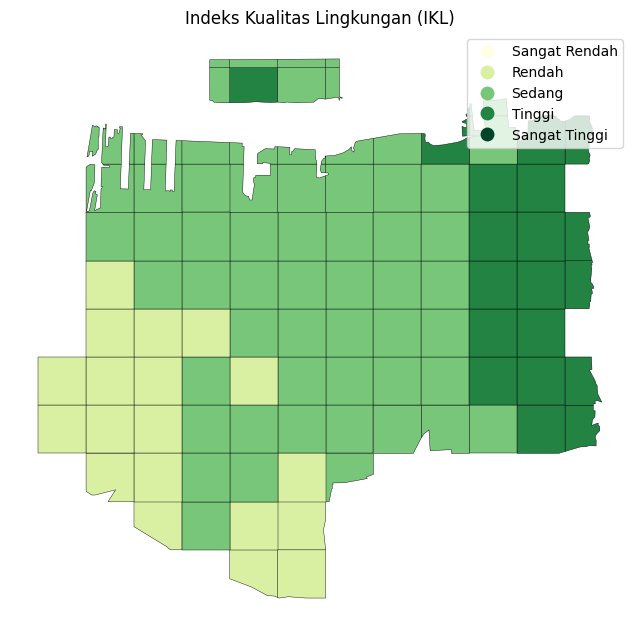

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
ikl.plot(
    ax=ax,
    column="IKL_KELAS",
    cmap="YlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    categorical=True,
)

ax.set_title("Indeks Kualitas Lingkungan (IKL)")
ax.set_axis_off()
plt.show()

## Exploration IKL

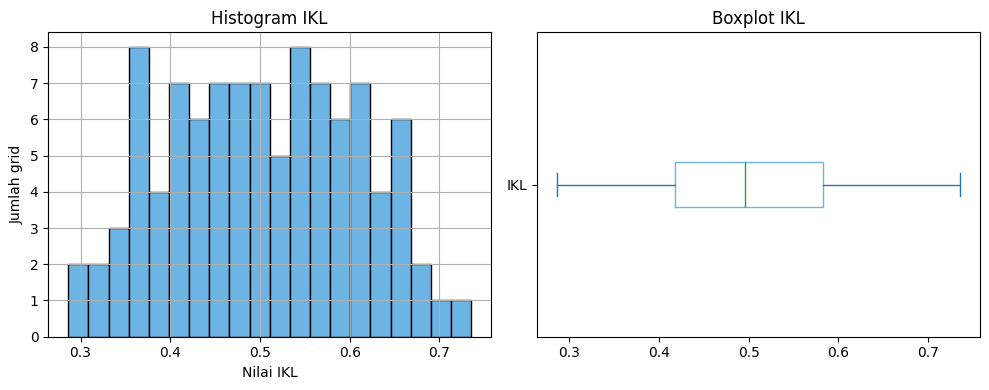

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ikl["IKL"].hist(bins=20, ax=axes[0], color="#6cb4e4", edgecolor="black")
axes[0].set_title("Histogram IKL")
axes[0].set_xlabel("Nilai IKL"); axes[0].set_ylabel("Jumlah grid")

ikl["IKL"].plot(kind="box", ax=axes[1], vert=False, color={"boxes":"#6cb4e4"})
axes[1].set_title("Boxplot IKL")
plt.tight_layout()
plt.show()


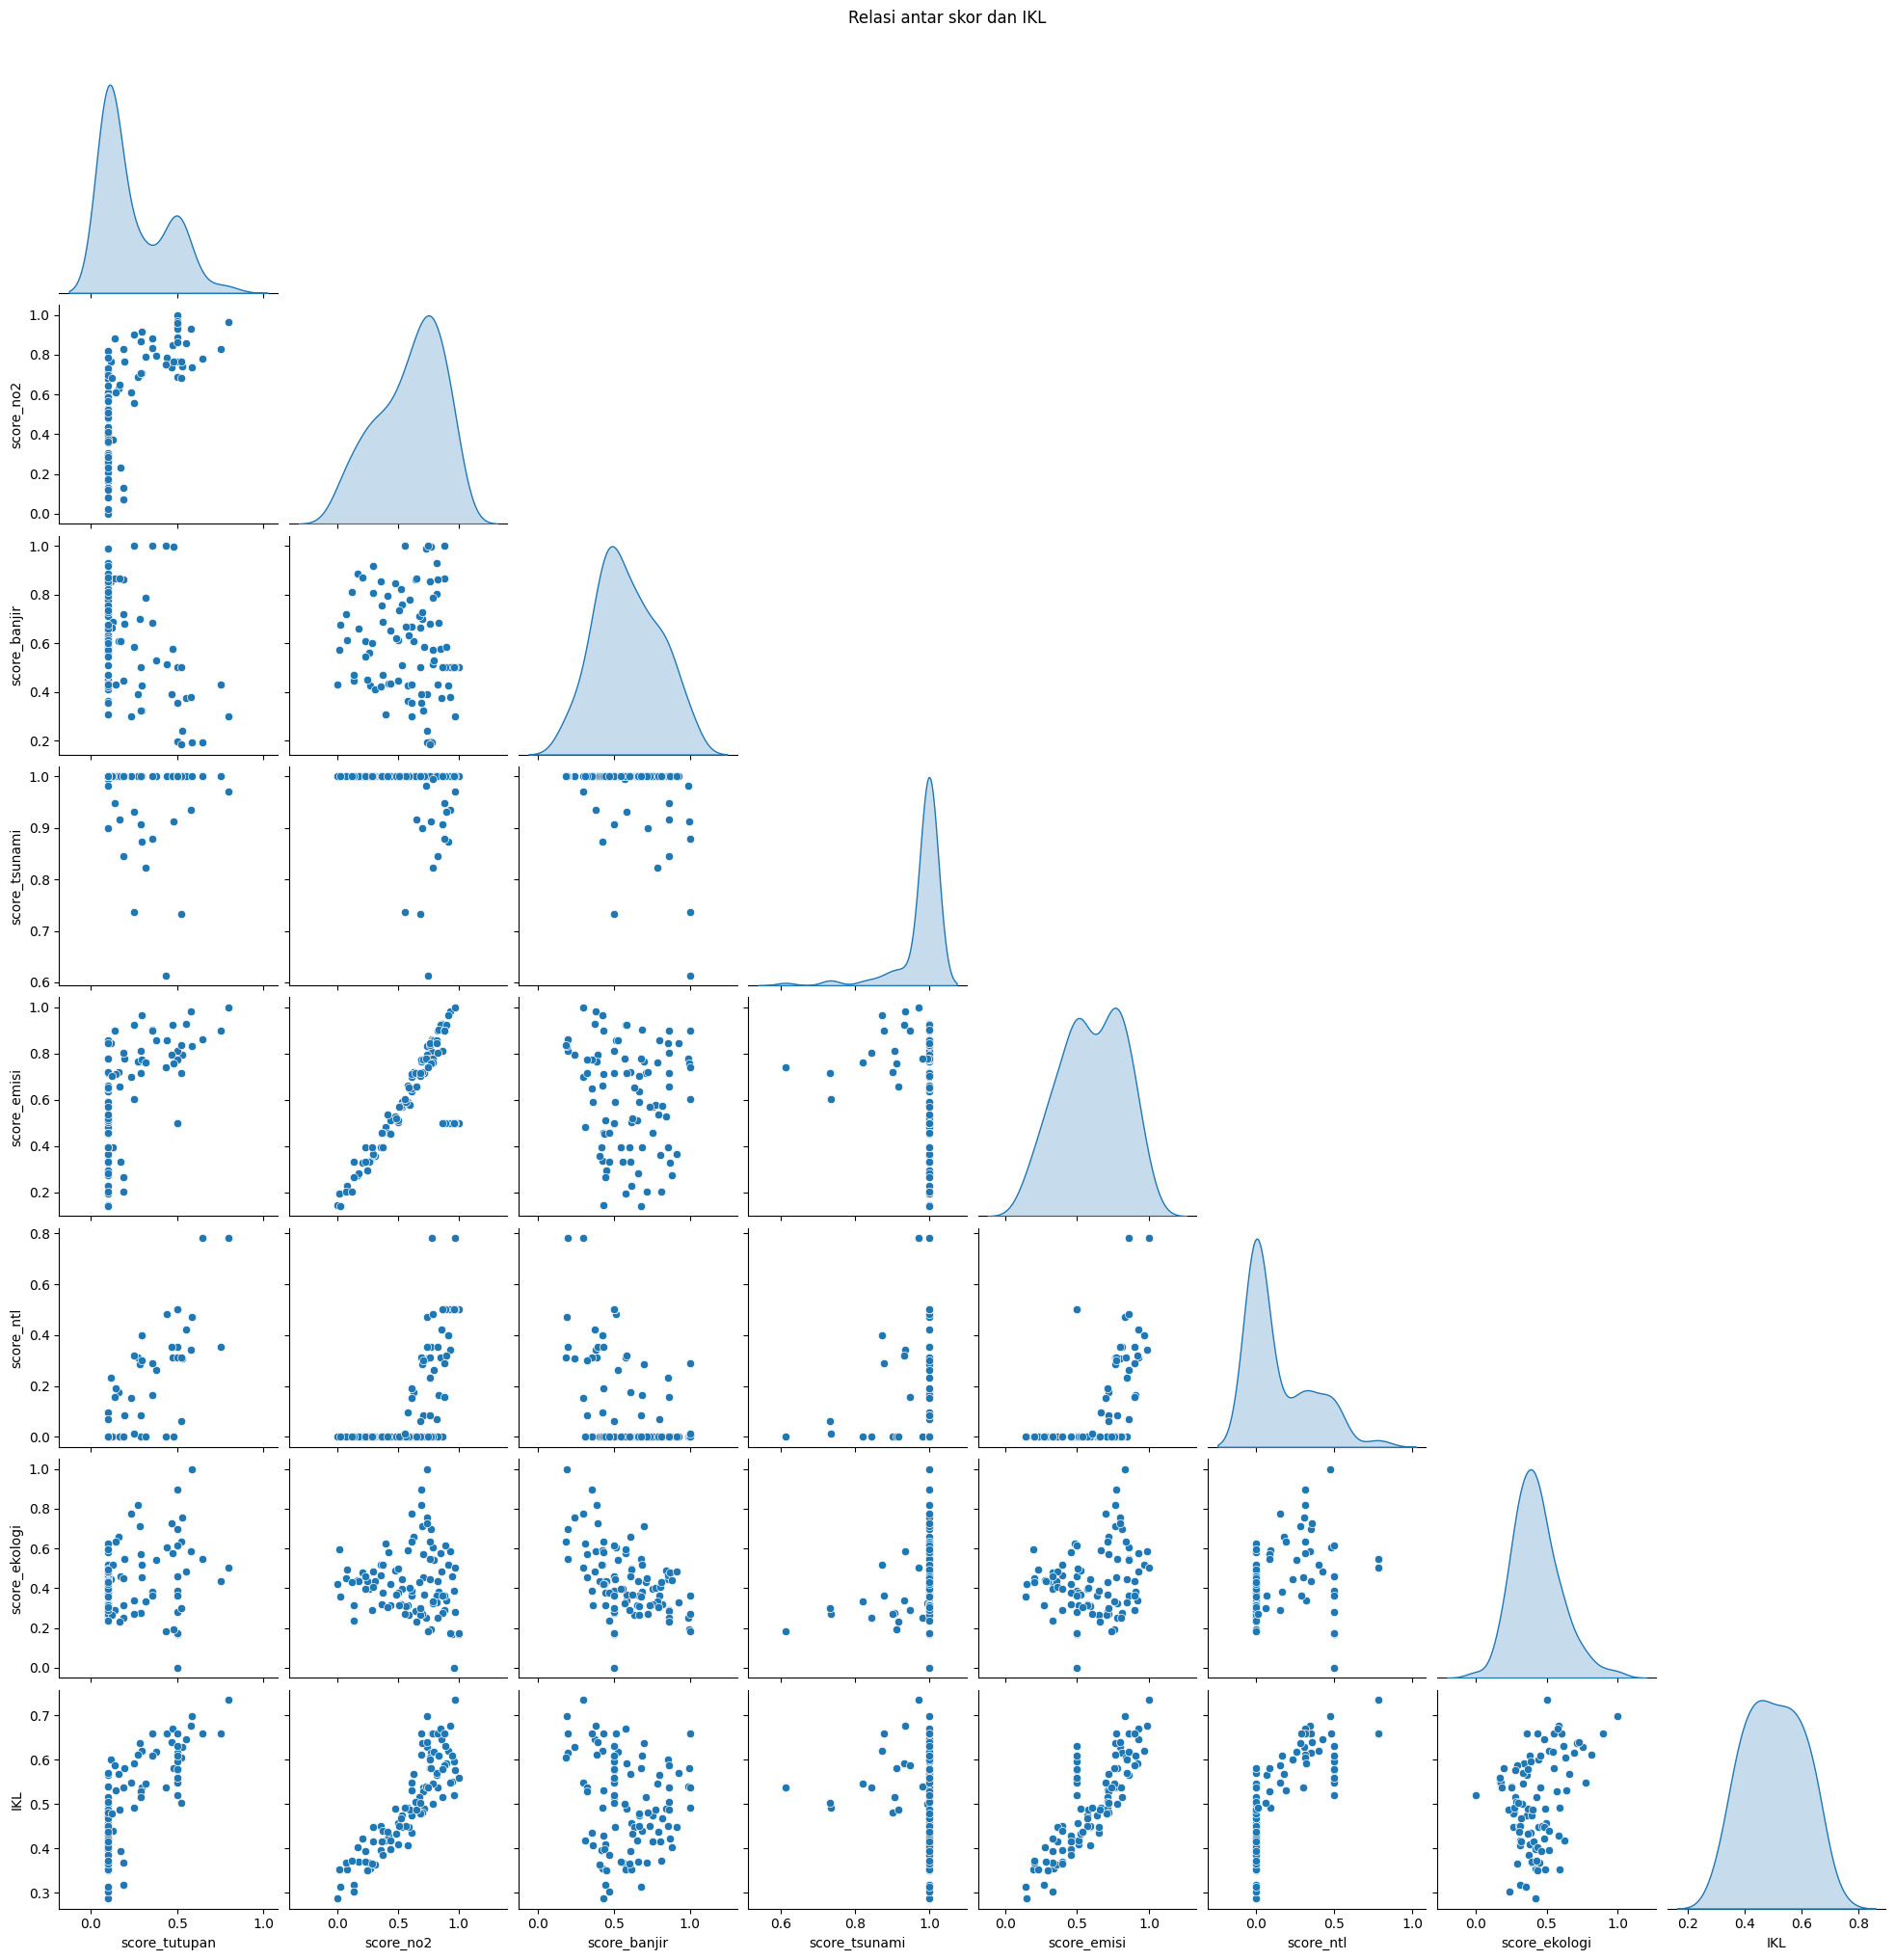

In [39]:
import seaborn as sns

score_cols = [
    "score_tutupan", "score_no2", "score_banjir", "score_tsunami",
    "score_emisi", "score_ntl", "score_ekologi"
]
sns.pairplot(ikl[score_cols + ["IKL"]], corner=True, diag_kind="kde")
plt.suptitle("Relasi antar skor dan IKL", y=1.02)
plt.show()


/var/folders/p0/dds400fd5ys_739l634yb7ch0000gn/T/ipykernel_19205/3419322538.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kelas_stats = ikl.groupby("IKL_KELAS")[score_cols].mean()


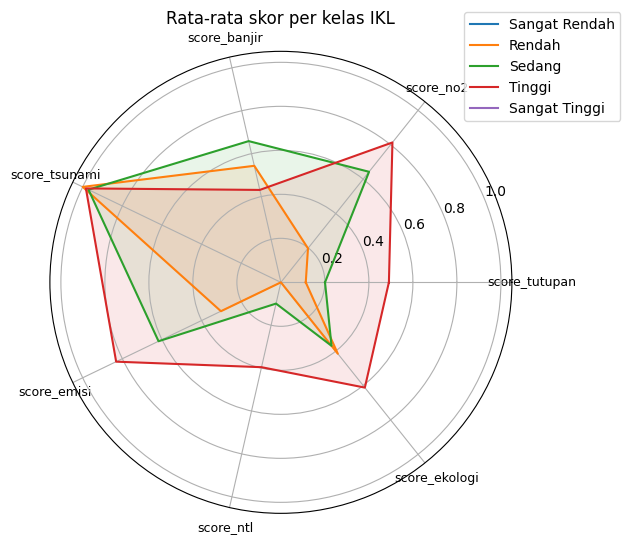

In [40]:
import numpy as np

score_cols = [
    "score_tutupan", "score_no2", "score_banjir",
    "score_tsunami", "score_emisi", "score_ntl", "score_ekologi"
]
kelas_stats = ikl.groupby("IKL_KELAS")[score_cols].mean()

labels = np.array(score_cols)
theta = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

for kelas, row in kelas_stats.iterrows():
    values = row.values
    values = np.append(values, values[0])      # tutup loop
    t = np.append(theta, theta[0])             # tambah titik awal di akhir
    ax.plot(t, values, label=kelas)
    ax.fill(t, values, alpha=0.1)

ax.set_xticks(theta)
ax.set_xticklabels(labels, fontsize=9)
ax.set_title("Rata-rata skor per kelas IKL")
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))
plt.show()


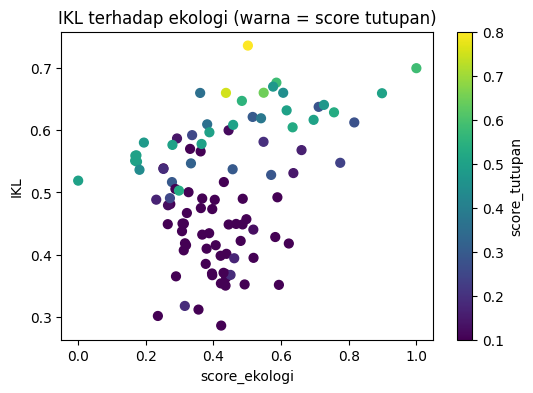

In [41]:
plt.figure(figsize=(6,4))
plt.scatter(ikl["score_ekologi"], ikl["IKL"], c=ikl["score_tutupan"], cmap="viridis", s=40)
plt.colorbar(label="score_tutupan")
plt.xlabel("score_ekologi"); plt.ylabel("IKL")
plt.title("IKL terhadap ekologi (warna = score tutupan)")
plt.show()


In [42]:
summary = ikl.groupby("IKL_KELAS")[score_cols + ["IKL"]].agg(["mean", "std"])
print(summary)


              score_tutupan           score_no2           score_banjir  \
                       mean       std      mean       std         mean   
IKL_KELAS                                                                
Sangat Rendah           NaN       NaN       NaN       NaN          NaN   
Rendah             0.113052  0.031091  0.197585  0.127701     0.543308   
Sedang             0.200606  0.151939  0.642735  0.204296     0.658437   
Tinggi             0.490952  0.139560  0.813220  0.085379     0.430859   
Sangat Tinggi           NaN       NaN       NaN       NaN          NaN   

                        score_tsunami           score_emisi            \
                    std          mean       std        mean       std   
IKL_KELAS                                                               
Sangat Rendah       NaN           NaN       NaN         NaN       NaN   
Rendah         0.117103      1.000000  0.000000    0.302505  0.096554   
Sedang         0.196493      0.970660  0.0

/var/folders/p0/dds400fd5ys_739l634yb7ch0000gn/T/ipykernel_19205/3170960121.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = ikl.groupby("IKL_KELAS")[score_cols + ["IKL"]].agg(["mean", "std"])


In [43]:
import os
import geopandas as gpd

output_folder = "output_geojson"
os.makedirs(output_folder, exist_ok=True)
for key, gdf in gdfs.items():
    if isinstance(gdf, gpd.GeoDataFrame) and not gdf.empty:
        if gdf.crs is None:
            gdf = gdf.set_crs(epsg=4326)
        output_path = os.path.join(output_folder, f"{key}.geojson")
        gdf.to_file(output_path, driver="GeoJSON")
        print(f"{key} berhasil disimpan ke {output_path}")
    else:
        print(f"{key} kosong atau bukan GeoDataFrame")

if isinstance(ikl, gpd.GeoDataFrame) and not ikl.empty:
    if ikl.crs is None:
        ikl = ikl.set_crs(epsg=4326)
    ikl_export = ikl[["IKL", "IKL_KELAS", "geometry"]]
    output_path = os.path.join(output_folder, "indeks_kualitas_lingkungan.geojson")
    ikl_export.to_file(output_path, driver="GeoJSON")
    print("IKL berhasil disimpan ke output_geojson/")
else:
    print("IKL tidak valid atau kosong")

tutupan_lahan berhasil disimpan ke output_geojson/tutupan_lahan.geojson
no2 berhasil disimpan ke output_geojson/no2.geojson
bahaya_banjir berhasil disimpan ke output_geojson/bahaya_banjir.geojson
bahaya_tsunami berhasil disimpan ke output_geojson/bahaya_tsunami.geojson
emisi_karbon berhasil disimpan ke output_geojson/emisi_karbon.geojson
ntl berhasil disimpan ke output_geojson/ntl.geojson
indeks_ekologi berhasil disimpan ke output_geojson/indeks_ekologi.geojson
batas_admin berhasil disimpan ke output_geojson/batas_admin.geojson
IKL berhasil disimpan ke output_geojson/
